In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import skeletonize
import itertools
from collections import defaultdict


In [2]:
IMG_PATH = "C:/programmering/DTU/robobot/data/line3.jpg"
CM_PATH = 'C:/programmering/DTU/robobot/config/camera/calibration_matrix.npy'
DIST_PATH = 'C:/programmering/DTU/robobot/config/camera/distortion_coefficients.npy'

In [3]:
mtx = np.load(CM_PATH)
dist = np.load(DIST_PATH)

In [4]:
img = cv2.imread(IMG_PATH)
# img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
img = cv2.resize(img, (820, 616))


In [5]:
def getContourCenter(contour):
    M = cv2.moments(contour)
    
    if M["m00"] == 0:
        return 0
    
    x = int(M["m10"]/M["m00"])
    y = int(M["m01"]/M["m00"])
    
    return [x,y]

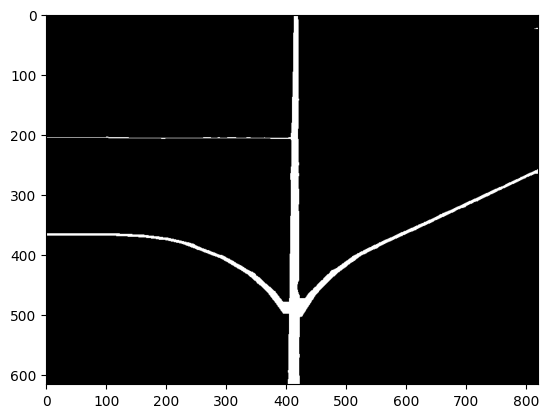

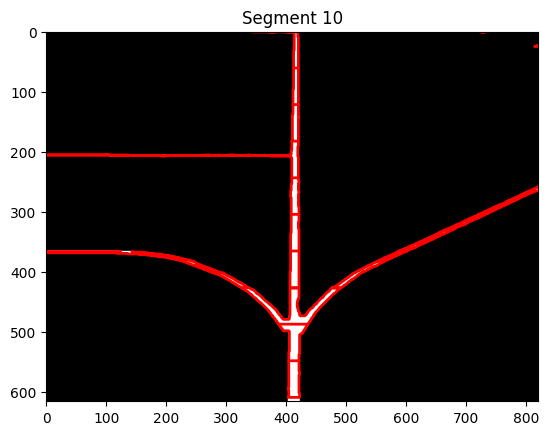

In [6]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


blurred = cv2.GaussianBlur(gray, (7, 7), 0)
(T, thresh) = cv2.threshold(blurred, 0, 255, cv2.THRESH_OTSU)
# thresh = cv2.adaptiveThreshold(
#     gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
# )


kernel = np.ones((5, 5), np.uint8)
eroded = cv2.erode(thresh, kernel, iterations=2)

plt.imshow(eroded, cmap="gray")
plt.show()



height, width, _ = img.shape
segments_height = height // 10
segments = [eroded[i*segments_height:(i+1)*segments_height, :] for i in range(10)]

# Display the segments
for i, segment in enumerate(segments):
    plt.imshow(segment, cmap="gray")
    contours, _ = cv2.findContours(segment, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
    
        center = getContourCenter(contour)
        
        plt.plot(contour[:, :, 0], contour[:, :, 1] + segments_height * i, 'r', linewidth=2)


plt.imshow(cv2.cvtColor(eroded, cv2.COLOR_BGR2RGB))
plt.title(f'Segment {i+1}')
plt.show()

# contours, _ = cv2.findContours(eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# main_contour = max(contours, key=cv2.contourArea)



# # Plot the contours
# plt.imshow(eroded, cmap="gray")
# plt.title("Contours")

# plt.plot(main_contour[:, :, 0], main_contour[:, :, 1], 'r', linewidth=2)
# plt.show()



In [27]:
skeleton = skeletonize(eroded // 255) * 255  # Convert back to 0-255

track = np.zeros_like(skeleton)

# Make sure the search starts from the center of the image and moves outwards in a horizontal manner.
found = False
center_col = skeleton.shape[1] // 2
indices = list(range(skeleton.shape[1]-1))
left_idx = indices[:center_col][::-1]
right_idx = indices[center_col:]
interlace = [None] * (len(left_idx) + len(right_idx))
interlace[::2] = left_idx
interlace[1::2] = right_idx

for i in reversed(range(skeleton.shape[0]-10, skeleton.shape[0])):
    if found:
        break
    for col in interlace:
        if skeleton[i, col] == 255:
            print("Found white pixel at", col, i)
            x, y = col, i
            found = True
            break

# Use a stack to perform depth-first search (DFS) to find all connected white pixels
stack = [(x, y, 0, None, None)]
routes = defaultdict(list)
routes_mapping = {0 : (None, None, None)}
route_idx = 0
while stack:
    cx, cy, prev_route_idx, prev_x, prev_y = stack.pop()
    
    # print(skeleton[cy, cx])
    # ymin = max(cy - 1, 0)
    # ymax = min(cy + 2, skeleton.shape[0] - 1)
    # xmin = max(cx - 1, 0)
    # xmax = min(cx + 2, skeleton.shape[1] - 1)
    # print(skeleton[ymin:ymax, xmin:xmax])
    end_of_route = True
    
    
    for dx, dy in list(itertools.product([-1, 0, 1], repeat=2)):
        nx, ny = cx + dx, cy + dy
        if 0 <= nx < skeleton.shape[1] and 0 <= ny < skeleton.shape[0]:
            if skeleton[ny, nx] == 255 and track[ny, nx] == 0:
                track[ny, nx] = 255
                stack.append((nx, ny, route_idx, cx, cy))
                routes[route_idx].append((nx, ny))
                
                if route_idx not in routes_mapping.keys():
                    routes_mapping[route_idx] = (prev_route_idx, cx, cy)
                
                end_of_route = False
    
    if end_of_route and route_idx in routes.keys():
        route_idx += 1            
        

# plt.imshow(track, cmap="gray")
# plt.show()



Found white pixel at 406 612


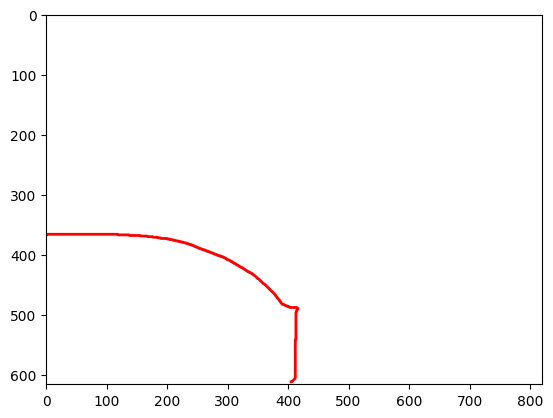

In [29]:
def get_full_route(route_idx, routes, routes_mapping):
    route = routes[route_idx]
    
    prev_route_idx, prev_x, prev_y = routes_mapping[route_idx]
    
    while prev_route_idx is not None:
        prev_route = routes[prev_route_idx]
        prev_route.index((prev_x, prev_y))
        route = prev_route[:prev_route.index((prev_x, prev_y))] + route
        prev_route_idx, prev_x, prev_y = routes_mapping[prev_route_idx]
        
        
    return route

def segment_route(route, distance):
    return route[::distance]    

def plot_route(route, skeleton, standalone=False, color='r'):
    plt.plot([x for x, y in route], [y for x, y in route], color, linewidth=2)
    plt.xlim(0, skeleton.shape[1])
    plt.ylim(skeleton.shape[0], 0)
    
    if standalone:
        plt.show()
    
plot_route(get_full_route(4, routes, routes_mapping), skeleton)

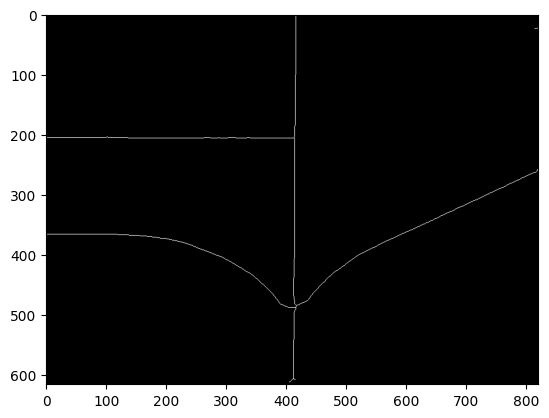

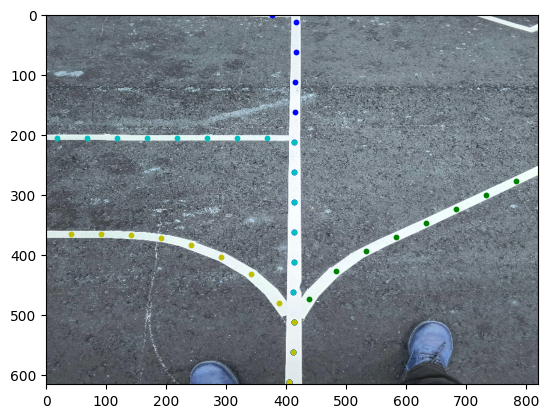

In [45]:
colors = ['r', 'g', 'b', 'c', 'y', 'k']

plt.imshow(skeleton, cmap="gray")
plt.show()

plt.imshow(img)
for i, (route_idx, route) in enumerate(routes.items()):
    full_route = get_full_route(route_idx, routes, routes_mapping)
    color = colors[i % len(colors)]
    # plot_route(full_route, skeleton, color=color)
    
    route = segment_route(full_route, 50)
    plt.scatter([x for x, y in route], [y for x, y in route], color=color, s=10)
    # plt.plot([x for x, y in route], [y for x, y in route], color, linewidth=2)
    plt.xlim(0, skeleton.shape[1])
    plt.ylim(skeleton.shape[0], 0)
plt.show()
    

0


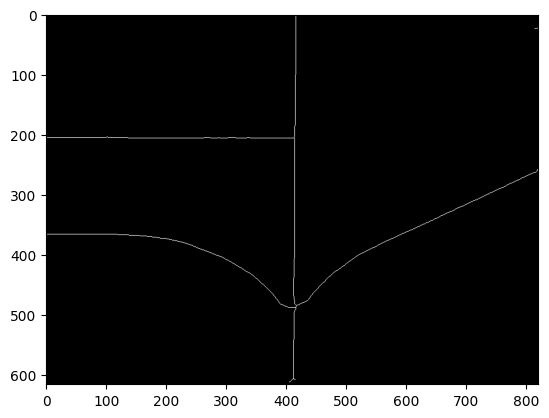